<a href="https://colab.research.google.com/github/xrueiii/2025IMProject/blob/main/%E5%B0%88%E9%A1%8C_%E7%B5%B1%E8%A8%98%E6%AD%A7%E8%A6%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ChatGPT
把 ChatGPT 的結果轉成 binary 表

In [ ]:
import pandas as pd

# 讀入 CSV
df = pd.read_csv("/content/classification_results_with_race_gpt.csv", encoding='latin1')


# 處理 concepts 欄位：缺值用空字串補上，再切割為 list
df['concepts_split'] = df['concepts'].fillna('').apply(lambda x: x.split(';') if x else [])

# 進行 multi-label binarization
mlb = MultiLabelBinarizer()
concepts_binary = pd.DataFrame(
    mlb.fit_transform(df['concepts_split']),
    columns=mlb.classes_,
    index=df.index
)

# 合併原始資料與 binary 結果
df_binary = pd.concat([df, concepts_binary], axis=1)

# 可選：只保留你關心的欄位（例如 article_id、title、quote + binary 類別）
# df_binary = df[['article_id', 'title', 'quote'] + list(mlb.classes_)]

# 儲存成新的 CSV 檔案
output_path = "/content/concepts_binary_output.csv"
df_binary.to_csv(output_path, index=False)

print(f"轉換完成！結果已儲存至：{output_path}")

轉換完成！結果已儲存至：/content/concepts_binary_output.csv


統計 binary 表中全部歧視次數的表

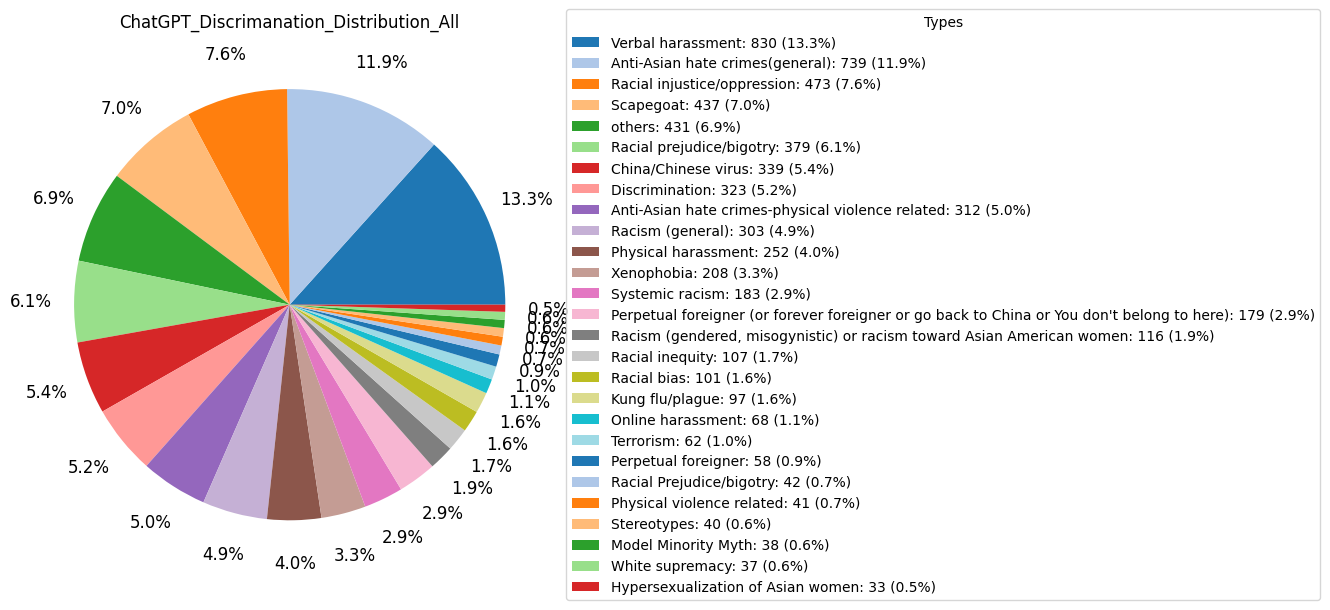

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取 CSV
df = pd.read_csv('/content/concepts_binary_output.csv')

# 計算各類歧視的數量
discrimination_counts = df.iloc[:, 7:].sum()

# 設定最低閾值，少於 5% 的類別歸入「其他」
threshold = discrimination_counts.sum() * 0.005
filtered_counts = discrimination_counts[discrimination_counts >= threshold]
other_count = discrimination_counts[discrimination_counts < threshold].sum()

# 增加「其他」類別
filtered_counts['others'] = other_count


# 排序歧視種類（由大到小）
filtered_counts = filtered_counts.sort_values(ascending=False)

# 設定顏色
colors = plt.get_cmap('tab20').colors[:len(filtered_counts)]  # 使用 `tab20` 色盤，確保顏色區分清楚

# 繪製圓餅圖
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(filtered_counts, colors=colors, autopct='%1.1f%%', pctdistance=1.2)  # 移動數字到外圈

# 計算百分比
total = filtered_counts.sum()
percentages = (filtered_counts / total * 100).round(1)

# 設定數字標籤大小
for autotext in autotexts:
    autotext.set_fontsize(12)

# 添加圖例（按大小排序），顯示數值與百分比
legend_labels = [f"{label}: {count} ({percent}%)" for label, count, percent in zip(filtered_counts.index, filtered_counts.values, percentages)]
plt.legend(wedges, legend_labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# 設定標題
plt.title('ChatGPT_Discrimanation_Distribution_All')

# 顯示圖表
plt.show()


合併 article 來看文章的日期，

In [ ]:
import pandas as pd

# 讀取兩個檔案
binary_df = pd.read_csv('/content/concepts_binary_output.csv')  # 這是包含歧視類型的文件
date_df = pd.read_csv('/content/articles (1).csv')  # 這是包含日期與 id 的文件

# 合併資料，根據 `id` 連接兩個表格
merged_df = pd.merge(binary_df, date_df, left_on="article_id", right_on="id")


# 確保日期格式正確
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')



# 確認資料整合成功
print(merged_df.head())


   article_id                                            title_x  \
0           1  Racism is the other virus sweeping America dur...   
1           1  Racism is the other virus sweeping America dur...   
2           1  Racism is the other virus sweeping America dur...   
3           1  Racism is the other virus sweeping America dur...   
4           1  Racism is the other virus sweeping America dur...   

                                               quote  \
0  Racism has its own virulence that is bad for t...   
1  But my parents were spurred to action after th...   
2  In recent years, they raised their voices agai...   
3  The resilience I learned from them has buoyed ...   
4  Now, I must speak out in the face of new attac...   

                                             context  \
0  Racism has its own virulence that is bad for t...   
1  But my parents were spurred to action after th...   
2  In recent years, they raised their voices agai...   
3  The resilience I learned fr

In [ ]:
merged_df.iloc[:, 7:] = merged_df.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')  # 強制轉為數值
print(merged_df.iloc[:, 7:].dtypes)  # 檢查欄位類型

Anti-Asian Hate Crimes(general)                      int64
Anti-Asian Hate Crimes-Physical Violence Related     int64
Anti-Asian hate crimes                               int64
Anti-Asian hate crimes(general)                      int64
Anti-Asian hate crimes-physical violence related     int64
                                                     ...  
date                                                 int64
summary                                             object
ARTICLE_TEXT                                        object
media_type                                          object
status                                              object
Length: 107, dtype: object


<ipython-input-21-34be892dd56c>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       1587427200000000000
1       1587427200000000000
2       1587427200000000000
3       1587427200000000000
4       1587427200000000000
               ...         
4858    1613520000000000000
4859    1613520000000000000
4860    1613520000000000000
4861    1613520000000000000
4862    1613520000000000000
Name: date, Length: 4863, dtype: int64' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  merged_df.iloc[:, 7:] = merged_df.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')  # 強制轉為數值


算事件前後的分布

In [ ]:
import pandas as pd

# 設定亞特蘭大事件日期（假設事件發生在 2021 年 3 月 16 日）
event_date = pd.to_datetime("2021-03-16")

# 強制轉換所有數據類型
merged_df.iloc[:, 7:] = merged_df.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# 確保日期格式正確，移除空值
merged_df['date'] = pd.to_datetime(merged_df['date'], unit='ns', errors='coerce')

merged_df = merged_df.dropna(subset=['date'])  # 移除沒有日期的行

# 標記文章為「事件前」或「事件後」
merged_df["period"] = merged_df["date"].apply(lambda x: "事件前" if x < event_date else "事件後")

# 確保只選擇歧視類別欄位
discrimination_cols = merged_df.columns.difference(["date", "period", "id", "article_id"])
merged_df[discrimination_cols] = merged_df[discrimination_cols].apply(pd.to_numeric, errors='coerce')


# 計算不同時期的歧視類型分佈
before_event = merged_df[merged_df["period"] == "事件前"][discrimination_cols].sum()
after_event = merged_df[merged_df["period"] == "事件後"][discrimination_cols].sum()

# 建立比較表格
comparison_df = pd.DataFrame({"事件前": before_event, "事件後": after_event})

# 計算變化比例（避免除以零錯誤）
comparison_df["變化率 (%)"] = ((comparison_df["事件後"] - comparison_df["事件前"]) / comparison_df["事件前"].replace(0, 1)) * 100

print(comparison_df)


                                                    事件前    事件後     變化率 (%)
ARTICLE_TEXT                                        0.0    0.0    0.000000
Anti-Asian Hate Crimes(general)                     0.0    1.0  100.000000
Anti-Asian Hate Crimes-Physical Violence Related    0.0    1.0  100.000000
Anti-Asian hate crimes                              0.0    2.0  200.000000
Anti-Asian hate crimes(general)                   265.0  474.0   78.867925
...                                                 ...    ...         ...
status                                              0.0    0.0    0.000000
summary                                             0.0    0.0    0.000000
title_x                                             0.0    0.0    0.000000
title_y                                             0.0    0.0    0.000000
victim                                              0.0    0.0    0.000000

[111 rows x 3 columns]


<ipython-input-22-8e2968723f2d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["period"] = merged_df["date"].apply(lambda x: "事件前" if x < event_date else "事件後")


生成事件前後的圓餅圖

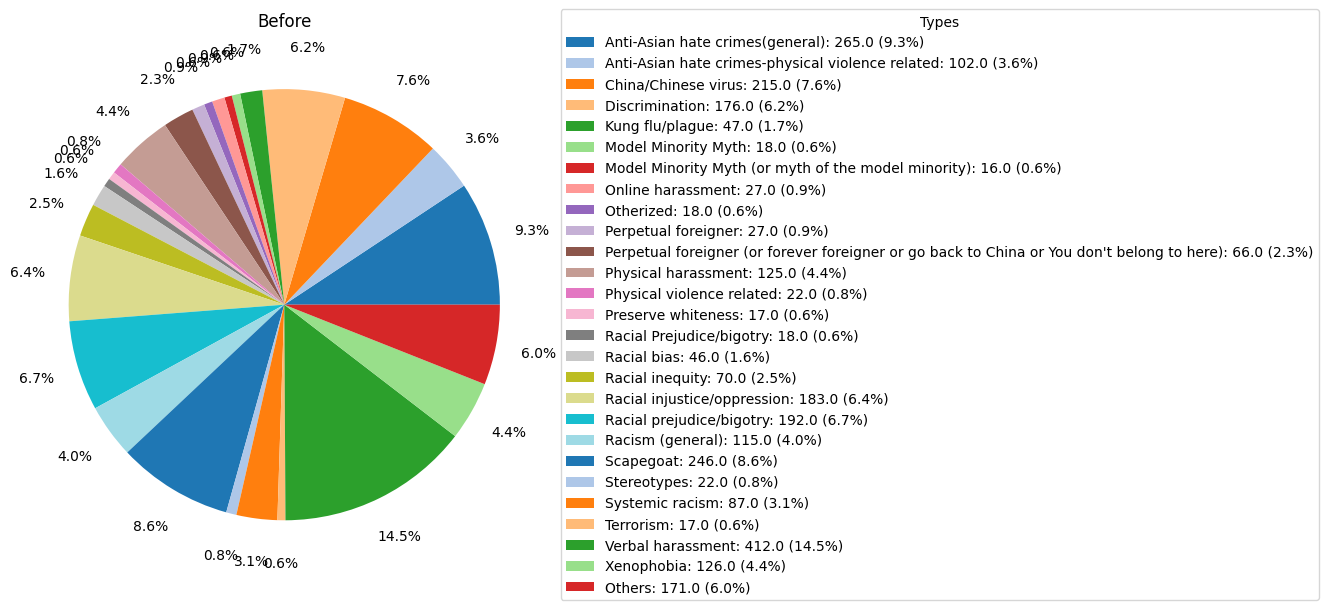

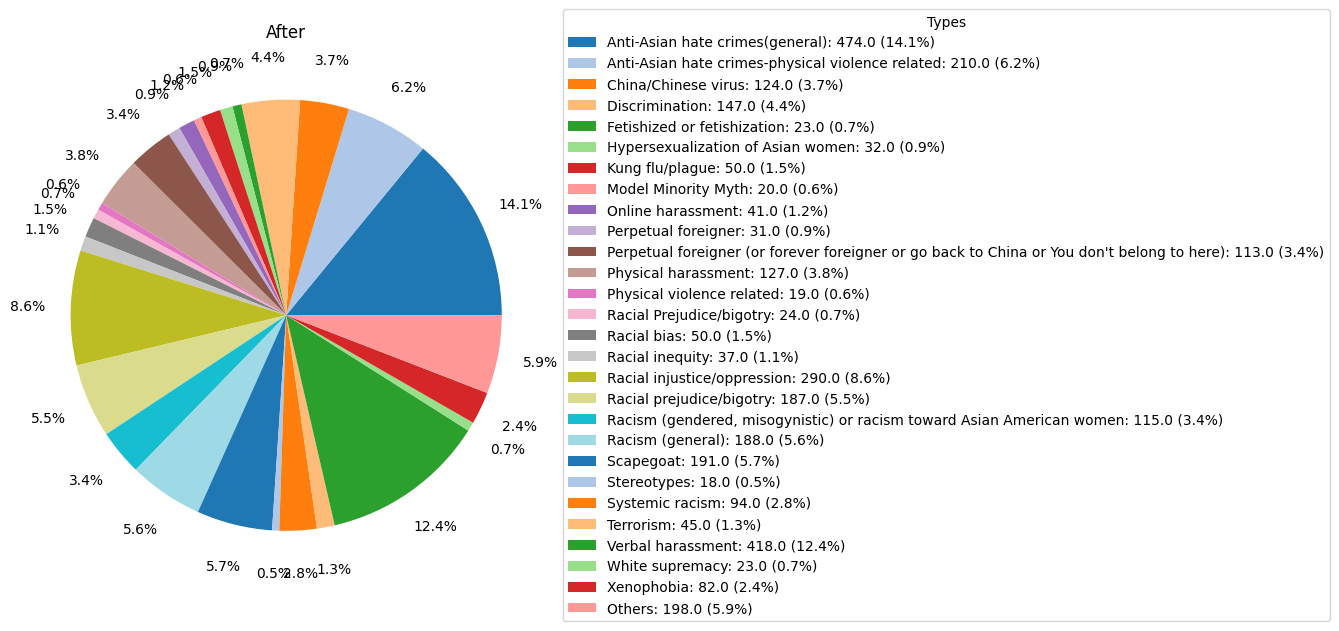

In [ ]:
import matplotlib.pyplot as plt

# 設定最低閾值（小於 0.5% 歸入 "其他"）
threshold = before_event.sum() * 0.005  # 事件前的總數的 0.5%
before_filtered = before_event[before_event >= threshold]
before_other = before_event[before_event < threshold].sum()
before_filtered['Others'] = before_other  # 加入 "其他" 類別

threshold = after_event.sum() * 0.005  # 事件後的總數的 0.5%
after_filtered = after_event[after_event >= threshold]
after_other = after_event[after_event < threshold].sum()
after_filtered['Others'] = after_other  # 加入 "其他" 類別

# 設定顏色
colors = plt.get_cmap('tab20').colors[:len(before_filtered)]

# 繪製事件前的圓餅圖（獨立圖片）
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(before_filtered, colors=colors, autopct='%1.1f%%', pctdistance=1.2)
ax.set_title("Before")

# 添加圖例（按大小排序）
legend_labels = [f"{label}: {count} ({percent:.1f}%)" for label, count, percent in zip(before_filtered.index, before_filtered.values, (before_filtered / before_filtered.sum() * 100))]
ax.legend(wedges, legend_labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('discrimination_before_event.png', dpi=300)
plt.show()

# 繪製事件後的圓餅圖（獨立圖片）
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(after_filtered, colors=colors, autopct='%1.1f%%', pctdistance=1.2)
ax.set_title("After")

# 添加圖例（按大小排序）
legend_labels = [f"{label}: {count} ({percent:.1f}%)" for label, count, percent in zip(after_filtered.index, after_filtered.values, (after_filtered / after_filtered.sum() * 100))]
ax.legend(wedges, legend_labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('discrimination_after_event.png', dpi=300)
plt.show()


分組長條圖

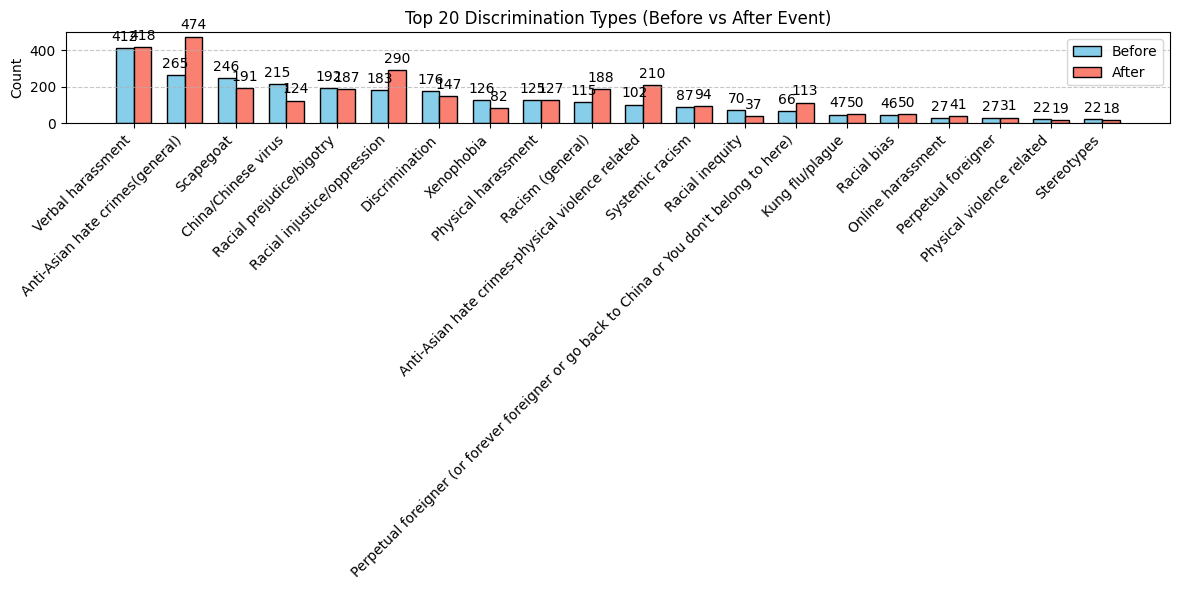

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假設 before_event 和 after_event 是 Pandas Series，索引為歧視類型
data = pd.DataFrame({
    "Before": before_event,
    "After": after_event
})

# 選取事件前的前十名類型（按值降序）
top10_types = data["Before"].nlargest(20).index
data_top10 = data.loc[top10_types]

# 繪圖設定
labels = data_top10.index
x = np.arange(len(labels))  # 類型標籤位置
width = 0.35  # 長條寬度

fig, ax = plt.subplots(figsize=(12, 6))

# 繪製分組長條
rects1 = ax.bar(x - width/2, data_top10["Before"], width, label="Before", color="skyblue", edgecolor="black")
rects2 = ax.bar(x + width/2, data_top10["After"], width, label="After", color="salmon", edgecolor="black")

# 標註數值（可選）
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.0f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 垂直偏移
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(rects1)
autolabel(rects2)

# 美化設定
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Top 20 Discrimination Types (Before vs After Event)")
ax.set_ylabel("Count")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("top20_grouped_bar.png", dpi=300)
plt.show()

堆疊長條圖

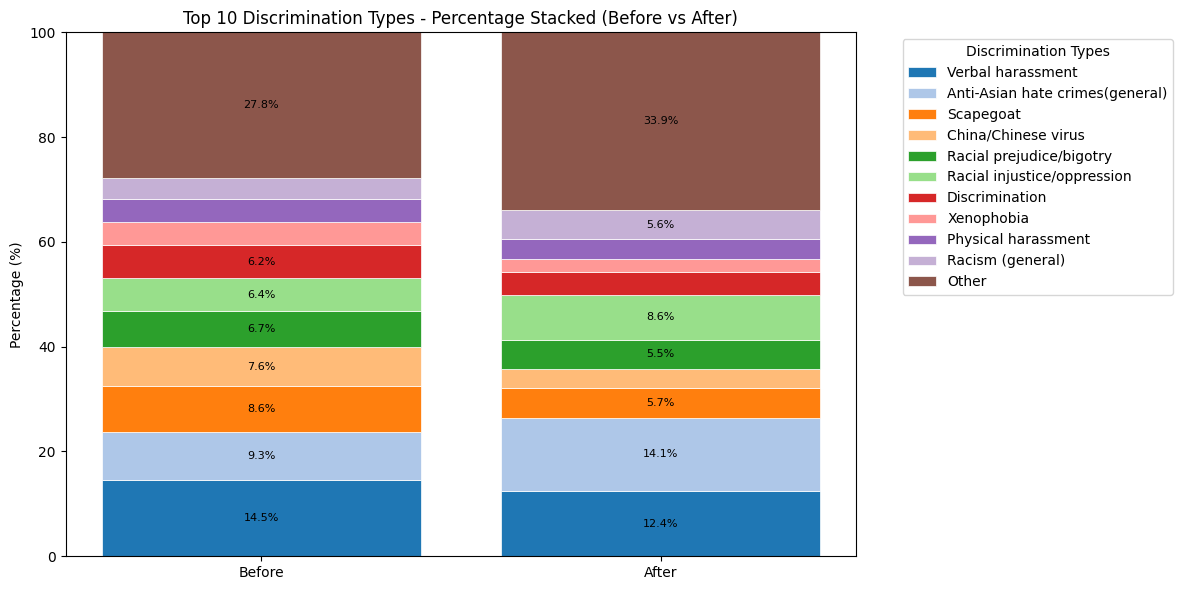

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假設 before_event 和 after_event 是 Pandas Series
data = pd.DataFrame({
    "Before": before_event,
    "After": after_event
})

# 選取事件前的前十名類型
top10_types = data["Before"].nlargest(10).index
data_top10 = data.loc[top10_types]

# 計算其他類型的總和（可選）
other_before = data["Before"].sum() - data_top10["Before"].sum()
other_after = data["After"].sum() - data_top10["After"].sum()
data_top10.loc["Other"] = [other_before, other_after]

# 轉換為百分比（每列總和為100%）
data_pct = data_top10.div(data_top10.sum(axis=0), axis=1) * 100

# 繪圖設定
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab20.colors[:len(data_pct)]  # 顏色列表

# 繪製堆疊長條（百分比版）
bottom_before = np.zeros(1)  # Before 的起始點
bottom_after = np.zeros(1)   # After 的起始點

for i, (dtype, row) in enumerate(data_pct.iterrows()):
    # Before 長條
    ax.bar(["Before"], [row["Before"]], bottom=bottom_before,
           label=dtype, color=colors[i], edgecolor="white", linewidth=0.5)
    # After 長條
    ax.bar(["After"], [row["After"]], bottom=bottom_after,
           color=colors[i], edgecolor="white", linewidth=0.5)

    # 標註百分比（可選）
    if row["Before"] > 5:  # 僅顯示占比>5%的標籤
        ax.text(0, bottom_before + row["Before"]/2, f"{row['Before']:.1f}%",
                ha="center", va="center", color="black", fontsize=8)
    if row["After"] > 5:
        ax.text(1, bottom_after + row["After"]/2, f"{row['After']:.1f}%",
                ha="center", va="center", color="black", fontsize=8)

    bottom_before += row["Before"]
    bottom_after += row["After"]

# 美化設定
ax.set_title("Top 10 Discrimination Types - Percentage Stacked (Before vs After)")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)  # 確保Y軸顯示0-100%
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Discrimination Types")
plt.tight_layout()
plt.savefig("stacked_bar_percentage.png", dpi=300)
plt.show()

本來是打算用一個直方圖，但有點失敗，可以不用理他

                                                    Before      After
ARTICLE_TEXT                                      0.000000   0.000000
Anti-Asian Hate Crimes(general)                   0.000000   0.029665
Anti-Asian Hate Crimes-Physical Violence Related  0.000000   0.029665
Anti-Asian hate crimes                            0.000000   0.059330
Anti-Asian hate crimes(general)                   9.311314  14.061109
...                                                    ...        ...
status                                            0.000000   0.000000
summary                                           0.000000   0.000000
title_x                                           0.000000   0.000000
title_y                                           0.000000   0.000000
victim                                            0.000000   0.000000

[111 rows x 2 columns]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20126 (\N{CJK UNIFIED IDEOGRAPH-4E9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34349 (\N{CJK UNIFIED IDEOGRAPH-862D}) missing from font(s) DejaVu Sans.
  fig.canvas

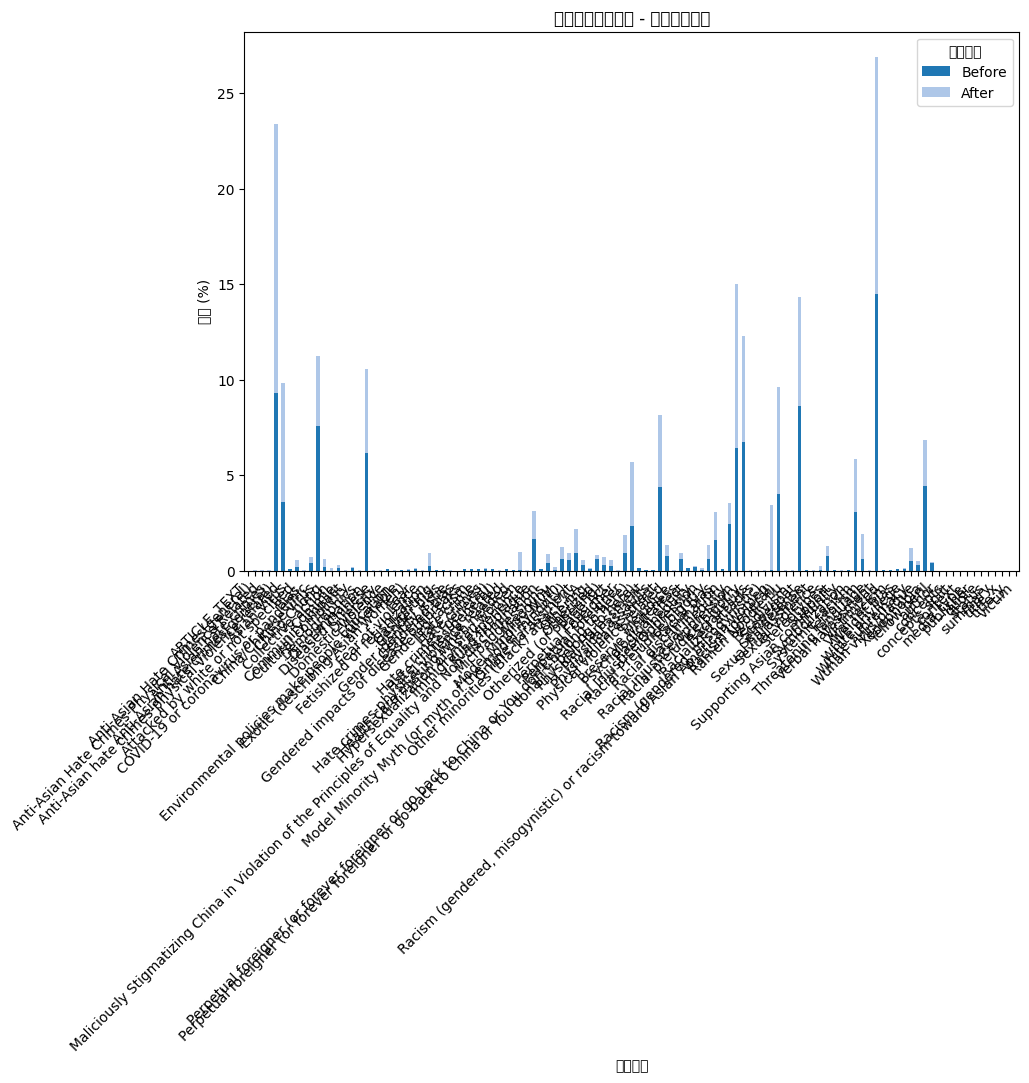

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 計算百分比
before_percent = before_event / before_event.sum() * 100
after_percent = after_event / after_event.sum() * 100

# 設定最低閾值（小於 0.5% 歸入 "其他"）
threshold = before_event.sum() * 0.005  # 事件前的總數的 0.5%
before_filtered = before_event[before_event >= threshold]
before_other = before_event[before_event < threshold].sum()
before_filtered['Others'] = before_other  # 加入 "其他" 類別

threshold = after_event.sum() * 0.005  # 事件後的總數的 0.5%
after_filtered = after_event[after_event >= threshold]
after_other = after_event[after_event < threshold].sum()
after_filtered['Others'] = after_other  # 加入 "其他" 類別


# 建立 DataFrame
comparison_df = pd.DataFrame({'Before': before_percent, 'After': after_percent})

print(comparison_df)  # 確認數據

# 設定圖表大小
fig, ax = plt.subplots(figsize=(10, 7))

# 設定顏色方案
colors = plt.get_cmap('tab20').colors[:len(comparison_df)]

# 繪製堆疊長條圖
comparison_df.plot(kind='bar', stacked=True, color=colors, ax=ax)

# 設定標題與標籤
ax.set_title("亞特蘭大事件前後 - 歧視類別變化")
ax.set_ylabel("比例 (%)")
ax.set_xlabel("歧視類別")
ax.legend(title="時間區間", loc="upper right")

plt.xticks(rotation=45, ha="right")  # 旋轉 X 軸標籤，讓它們更清晰
plt.show()


###Deepseek
以下程式碼的變數名稱都和ChatGPT那邊一樣(完全就是複製那邊的)，所以執行的時候可能要注意一下




In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# 讀入 CSV
df = pd.read_csv("/content/classification_results_with_race_deepseek.csv", encoding='latin1')


# 處理 concepts 欄位：缺值用空字串補上，再切割為 list
df['concepts_split'] = df['concepts'].fillna('').apply(lambda x: x.split(';') if x else [])

# 進行 multi-label binarization
mlb = MultiLabelBinarizer()
concepts_binary = pd.DataFrame(
    mlb.fit_transform(df['concepts_split']),
    columns=mlb.classes_,
    index=df.index
)

# 合併原始資料與 binary 結果
df_binary = pd.concat([df, concepts_binary], axis=1)

# 可選：只保留你關心的欄位（例如 article_id、title、quote + binary 類別）
# df_binary = df[['article_id', 'title', 'quote'] + list(mlb.classes_)]

# 儲存成新的 CSV 檔案
output_path = "/content/concepts_binary_output_deepseek.csv"
df_binary.to_csv(output_path, index=False)

print(f"轉換完成！結果已儲存至：{output_path}")

轉換完成！結果已儲存至：/content/concepts_binary_output_deepseek.csv


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 157 (\x9d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


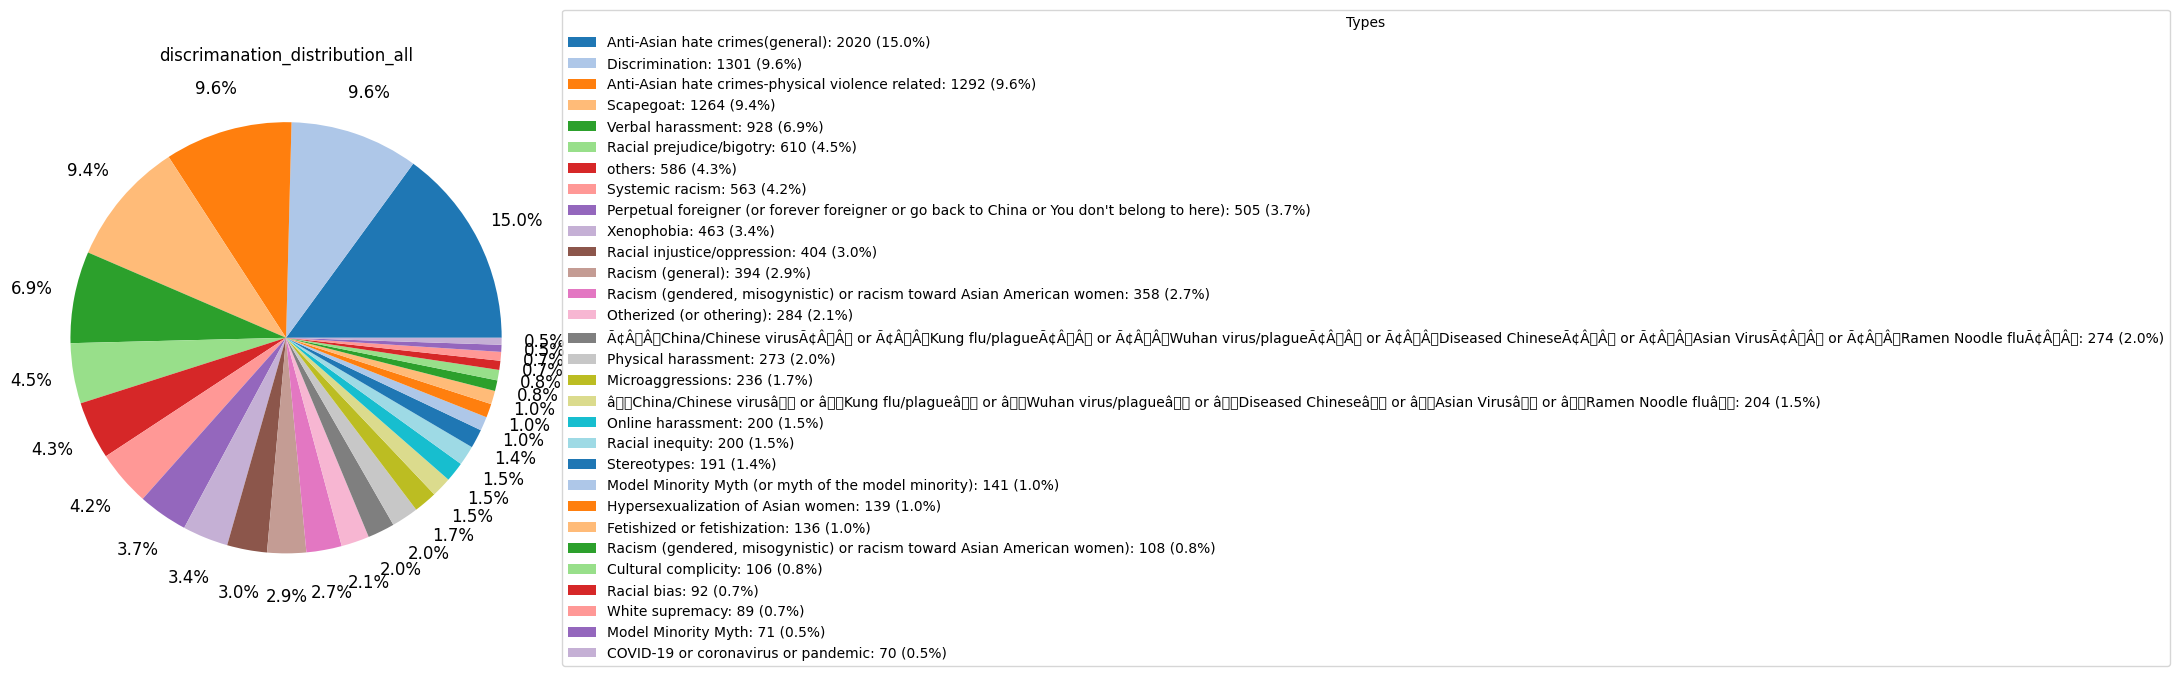

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取 CSV
df = pd.read_csv('/content/concepts_binary_output_deepseek.csv')

# 計算各類歧視的數量
discrimination_counts = df.iloc[:, 7:].sum()

# 設定最低閾值，少於 5% 的類別歸入「其他」
threshold = discrimination_counts.sum() * 0.005
filtered_counts = discrimination_counts[discrimination_counts >= threshold]
other_count = discrimination_counts[discrimination_counts < threshold].sum()

# 增加「其他」類別
filtered_counts['others'] = other_count


# 排序歧視種類（由大到小）
filtered_counts = filtered_counts.sort_values(ascending=False)

# 設定顏色
colors = plt.get_cmap('tab20').colors[:len(filtered_counts)]  # 使用 `tab20` 色盤，確保顏色區分清楚

# 繪製圓餅圖
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(filtered_counts, colors=colors, autopct='%1.1f%%', pctdistance=1.2)  # 移動數字到外圈

# 計算百分比
total = filtered_counts.sum()
percentages = (filtered_counts / total * 100).round(1)

# 設定數字標籤大小
for autotext in autotexts:
    autotext.set_fontsize(12)

# 添加圖例（按大小排序），顯示數值與百分比
legend_labels = [f"{label}: {count} ({percent}%)" for label, count, percent in zip(filtered_counts.index, filtered_counts.values, percentages)]
plt.legend(wedges, legend_labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# 設定標題
plt.title('discrimanation_distribution_all')

# 顯示圖表
plt.show()


In [ ]:
import pandas as pd

# 讀取兩個檔案
binary_df = pd.read_csv('/content/concepts_binary_output_deepseek.csv')  # 這是包含歧視類型的文件
date_df = pd.read_csv('/content/articles (1).csv')  # 這是包含日期與 id 的文件

# 合併資料，根據 `id` 連接兩個表格
merged_df = pd.merge(binary_df, date_df, left_on="article_id", right_on="id")


# 確保日期格式正確
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')



# 確認資料整合成功
print(merged_df.head())


   article_id                                            title_x  \
0           1  Racism is the other virus sweeping America dur...   
1           1  Racism is the other virus sweeping America dur...   
2           1  Racism is the other virus sweeping America dur...   
3           1  Racism is the other virus sweeping America dur...   
4           1  Racism is the other virus sweeping America dur...   

                                               quote  \
0  As Japanese Americans, they experienced as chi...   
1  With the coronavirus pandemic today, they are ...   
2  I can't remain silent as I witness the bigotry...   
3  Racism has its own virulence that is bad for t...   
4  Despite prejudice and fear among many Chicago ...   

                                             context  \
0  My parents have seen it all. As Japanese Ameri...   
1  With the coronavirus pandemic today, they are ...   
2  Now, as a Chicagoan who for nearly two decades...   
3  Racism has its own virulenc

In [ ]:
merged_df.iloc[:, 7:] = merged_df.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')  # 強制轉為數值
print(merged_df.iloc[:, 7:].dtypes)  # 檢查欄位類型

import pandas as pd

# 設定亞特蘭大事件日期（假設事件發生在 2021 年 3 月 16 日）
event_date = pd.to_datetime("2021-03-16")

# 強制轉換所有數據類型
merged_df.iloc[:, 7:] = merged_df.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')

# 確保日期格式正確，移除空值
merged_df['date'] = pd.to_datetime(merged_df['date'], unit='ns', errors='coerce')

merged_df = merged_df.dropna(subset=['date'])  # 移除沒有日期的行

# 標記文章為「事件前」或「事件後」
merged_df["period"] = merged_df["date"].apply(lambda x: "事件前" if x < event_date else "事件後")

# 確保只選擇歧視類別欄位
discrimination_cols = merged_df.columns.difference(["date", "period", "id", "article_id"])
merged_df[discrimination_cols] = merged_df[discrimination_cols].apply(pd.to_numeric, errors='coerce')


# 計算不同時期的歧視類型分佈
before_event = merged_df[merged_df["period"] == "事件前"][discrimination_cols].sum()
after_event = merged_df[merged_df["period"] == "事件後"][discrimination_cols].sum()

# 建立比較表格
comparison_df = pd.DataFrame({"事件前": before_event, "事件後": after_event})

# 計算變化比例（避免除以零錯誤）
comparison_df["變化率 (%)"] = ((comparison_df["事件後"] - comparison_df["事件前"]) / comparison_df["事件前"].replace(0, 1)) * 100

print(comparison_df)



"China/Chinese virus" or "Kung flu/plague" or "Wuhan virus/plague" or "Diseased Chinese" or "Asian Virus" or "Ramen Noodle flu"     int64
"Commie"                                                                                                                            int64
Anti-Asian hate crimes(general)                                                                                                     int64
Anti-Asian hate crimes-physical violence related                                                                                    int64
Attacked by white or not specified                                                                                                  int64
                                                                                                                                    ...  
date                                                                                                                                int64
summary                           

<ipython-input-30-5a1b5b3db6e6>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       1587427200000000000
1       1587427200000000000
2       1587427200000000000
3       1587427200000000000
4       1587427200000000000
               ...         
8651    1613520000000000000
8652    1613520000000000000
8653    1613520000000000000
8654    1613520000000000000
8655    1613520000000000000
Name: date, Length: 8656, dtype: int64' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  merged_df.iloc[:, 7:] = merged_df.iloc[:, 7:].apply(pd.to_numeric, errors='coerce')  # 強制轉為數值
<ipython-input-30-5a1b5b3db6e6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

<ipython-input-31-2e2b09123d4f>:26: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  plt.savefig('discrimination_before_event.png', dpi=300)
<ipython-input-31-2e2b09123d4f>:26: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  plt.savefig('discrimination_before_event.png', dpi=300)
<ipython-input-31-2e2b09123d4f>:26: UserWarning: Glyph 157 (\x9d) missing from font(s) DejaVu Sans.
  plt.savefig('discrimination_before_event.png', dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 157 (\x9d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

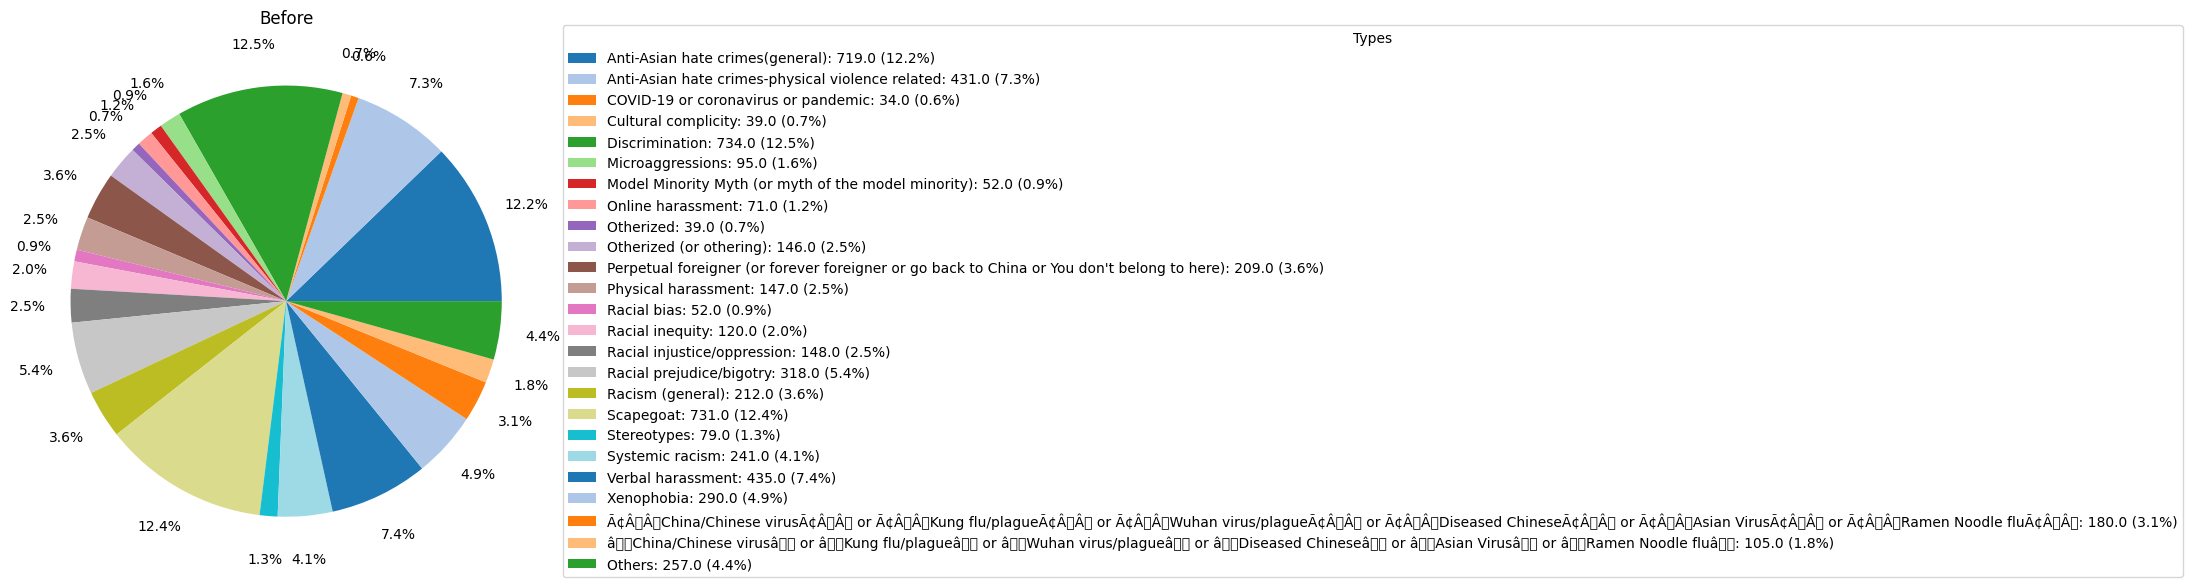

<ipython-input-31-2e2b09123d4f>:38: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  plt.savefig('discrimination_after_event.png', dpi=300)
<ipython-input-31-2e2b09123d4f>:38: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  plt.savefig('discrimination_after_event.png', dpi=300)
<ipython-input-31-2e2b09123d4f>:38: UserWarning: Glyph 157 (\x9d) missing from font(s) DejaVu Sans.
  plt.savefig('discrimination_after_event.png', dpi=300)


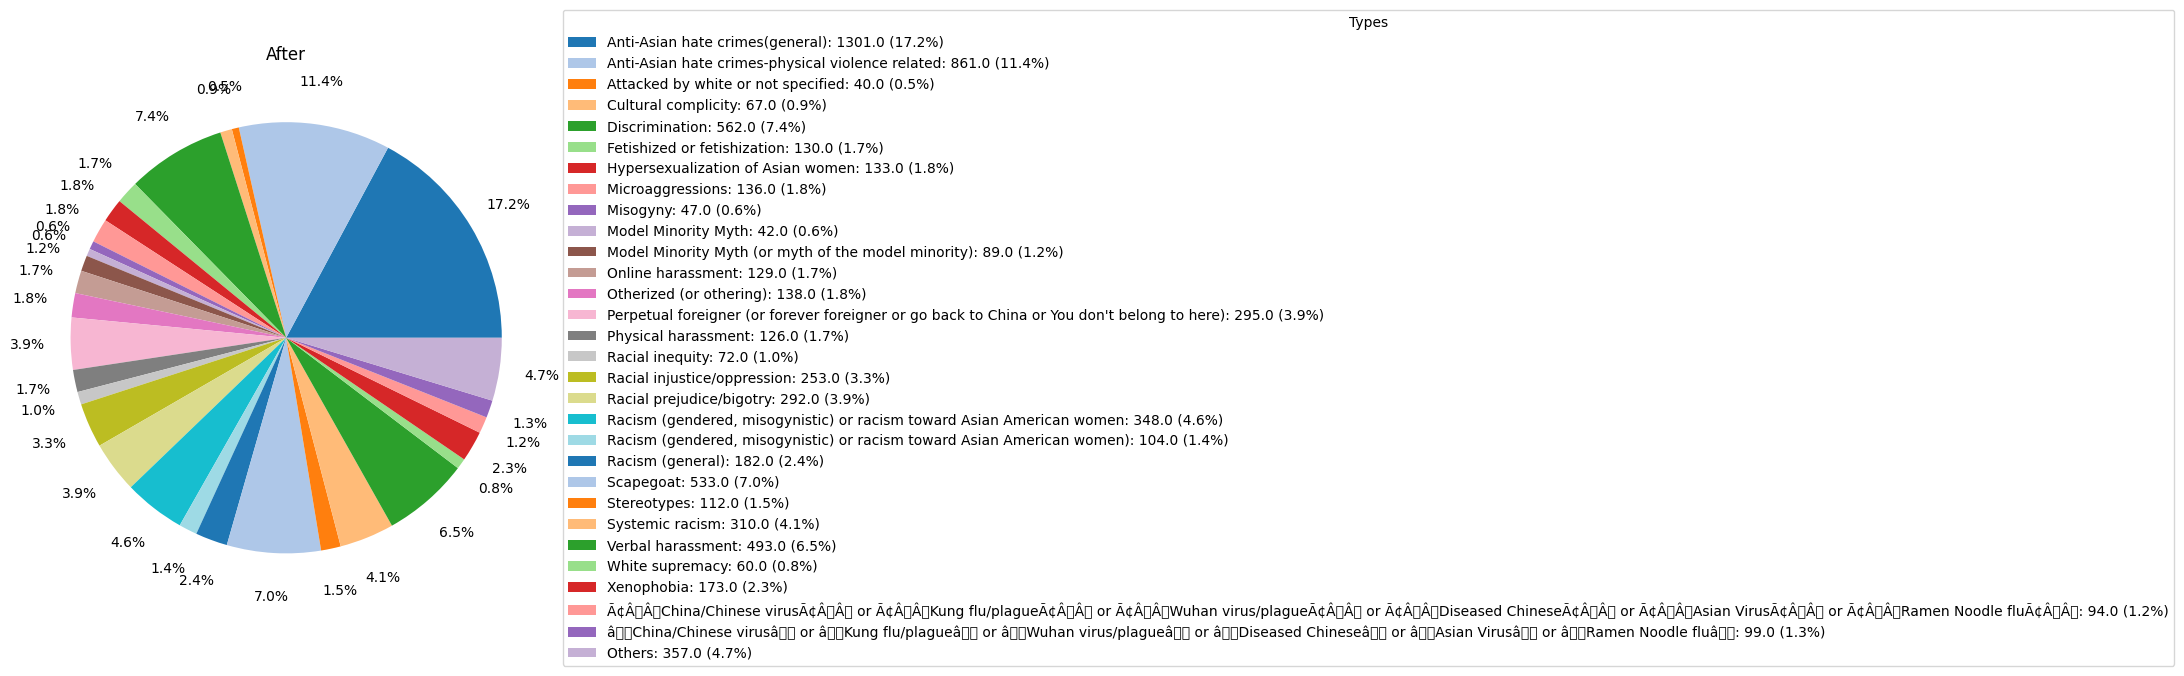

In [ ]:
import matplotlib.pyplot as plt

# 設定最低閾值（小於 0.5% 歸入 "其他"）
threshold = before_event.sum() * 0.005  # 事件前的總數的 0.5%
before_filtered = before_event[before_event >= threshold]
before_other = before_event[before_event < threshold].sum()
before_filtered['Others'] = before_other  # 加入 "其他" 類別

threshold = after_event.sum() * 0.005  # 事件後的總數的 0.5%
after_filtered = after_event[after_event >= threshold]
after_other = after_event[after_event < threshold].sum()
after_filtered['Others'] = after_other  # 加入 "其他" 類別

# 設定顏色
colors = plt.get_cmap('tab20').colors[:len(before_filtered)]

# 繪製事件前的圓餅圖（獨立圖片）
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(before_filtered, colors=colors, autopct='%1.1f%%', pctdistance=1.2)
ax.set_title("Before")

# 添加圖例（按大小排序）
legend_labels = [f"{label}: {count} ({percent:.1f}%)" for label, count, percent in zip(before_filtered.index, before_filtered.values, (before_filtered / before_filtered.sum() * 100))]
ax.legend(wedges, legend_labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('discrimination_before_event.png', dpi=300)
plt.show()

# 繪製事件後的圓餅圖（獨立圖片）
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(after_filtered, colors=colors, autopct='%1.1f%%', pctdistance=1.2)
ax.set_title("After")

# 添加圖例（按大小排序）
legend_labels = [f"{label}: {count} ({percent:.1f}%)" for label, count, percent in zip(after_filtered.index, after_filtered.values, (after_filtered / after_filtered.sum() * 100))]
ax.legend(wedges, legend_labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('discrimination_after_event.png', dpi=300)
plt.show()


<ipython-input-32-84de25083f44>:47: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-32-84de25083f44>:47: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-32-84de25083f44>:47: UserWarning: Glyph 157 (\x9d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-32-84de25083f44>:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
<ipython-input-32-84de25083f44>:48: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  plt.savefig("top20_grouped_bar.png", dpi=300)
<ipython-input-32-84de25083f44>:48: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  plt.savefig("top20_grouped_bar.png", dpi=300)
<ipython-input-32-84de25083f44>:48: UserWarning: Glyph 157 (\x9d) missing from font(s) DejaVu Sans.
  plt.savefig("top20_grouped_bar.png", dpi=300)
/usr/

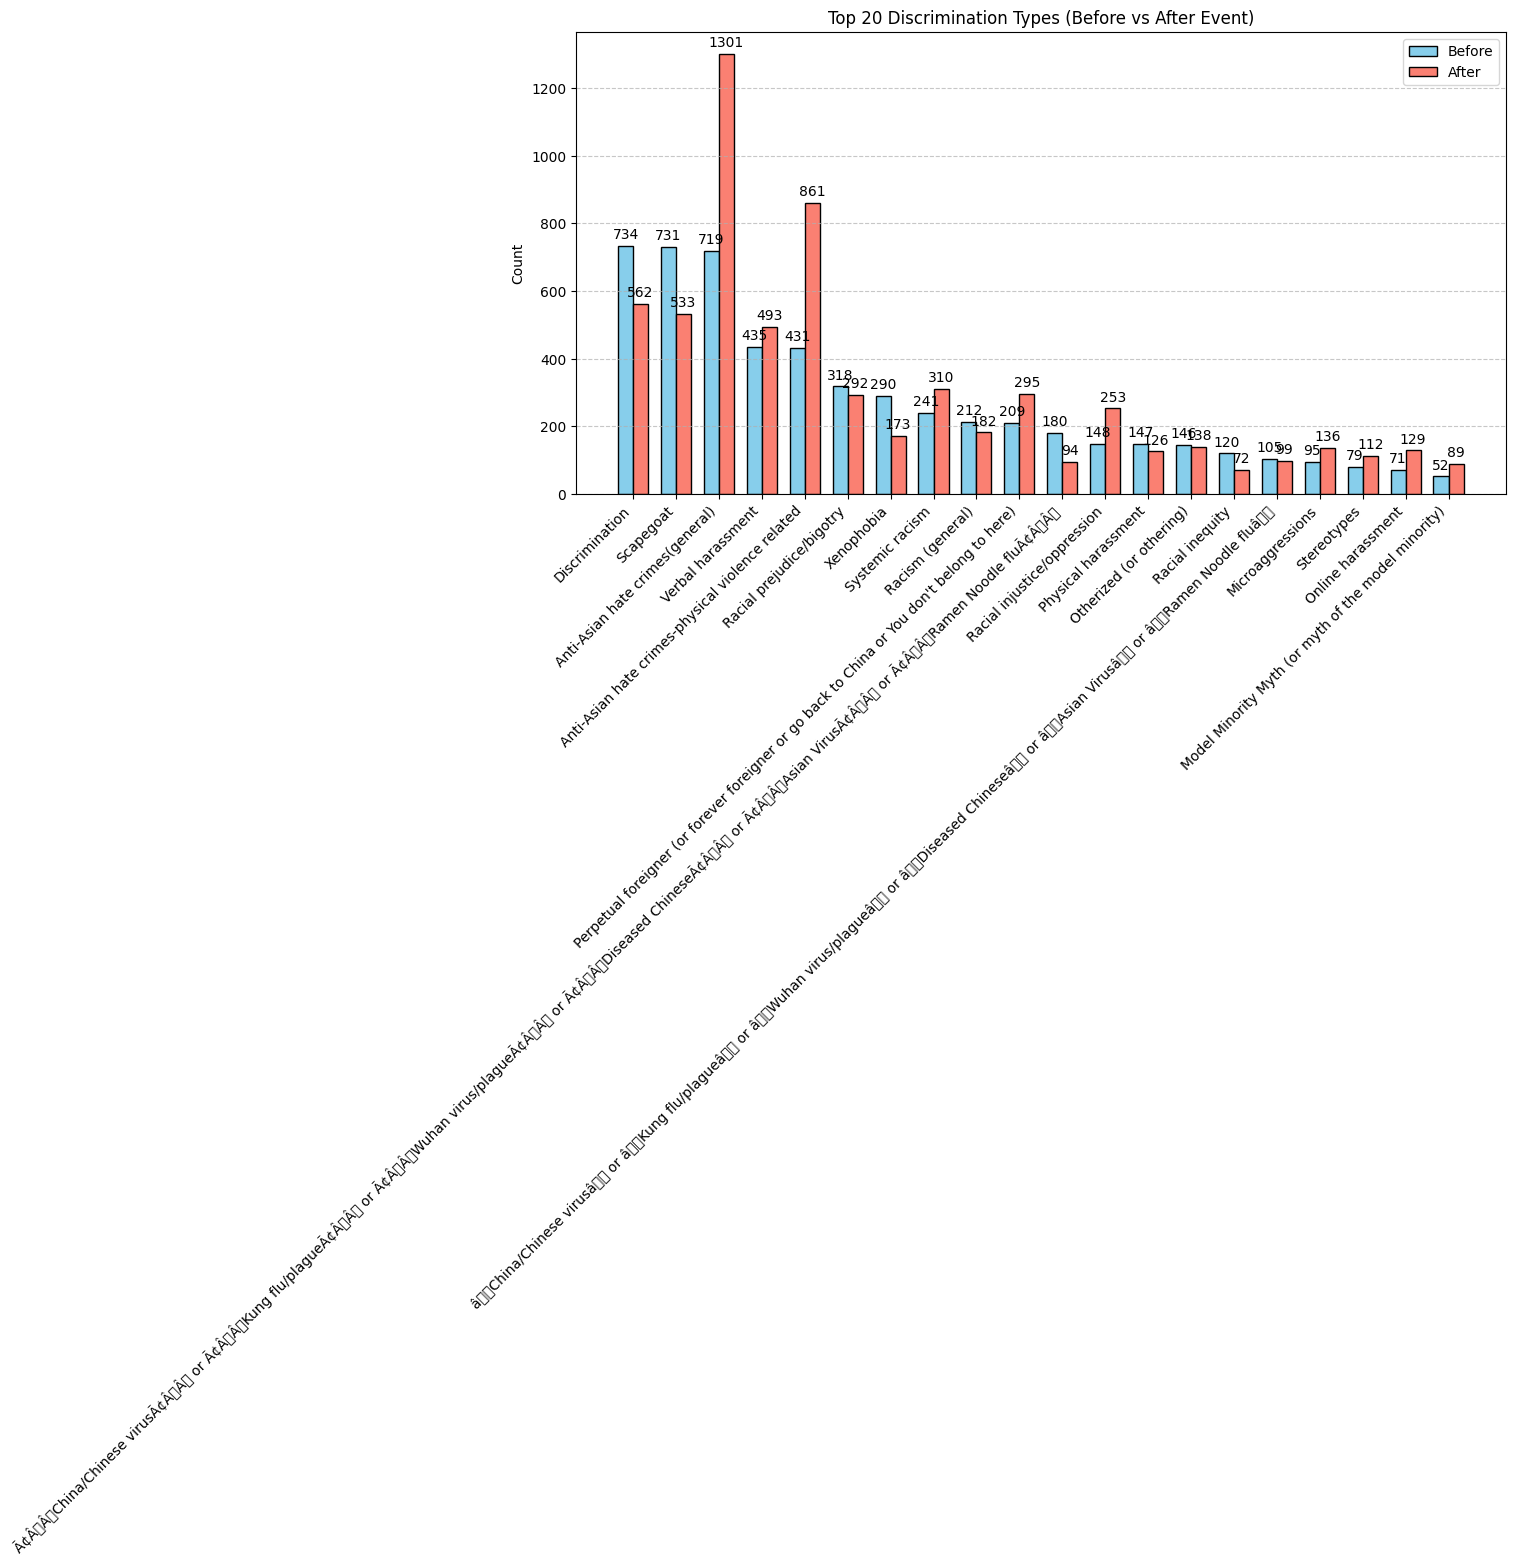

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假設 before_event 和 after_event 是 Pandas Series，索引為歧視類型
data = pd.DataFrame({
    "Before": before_event,
    "After": after_event
})

# 選取事件前的前十名類型（按值降序）
top10_types = data["Before"].nlargest(20).index
data_top10 = data.loc[top10_types]

# 繪圖設定
labels = data_top10.index
x = np.arange(len(labels))  # 類型標籤位置
width = 0.35  # 長條寬度

fig, ax = plt.subplots(figsize=(12, 6))

# 繪製分組長條
rects1 = ax.bar(x - width/2, data_top10["Before"], width, label="Before", color="skyblue", edgecolor="black")
rects2 = ax.bar(x + width/2, data_top10["After"], width, label="After", color="salmon", edgecolor="black")

# 標註數值（可選）
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.0f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 垂直偏移
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(rects1)
autolabel(rects2)

# 美化設定
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Top 20 Discrimination Types (Before vs After Event)")
ax.set_ylabel("Count")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("top20_grouped_bar.png", dpi=300)
plt.show()

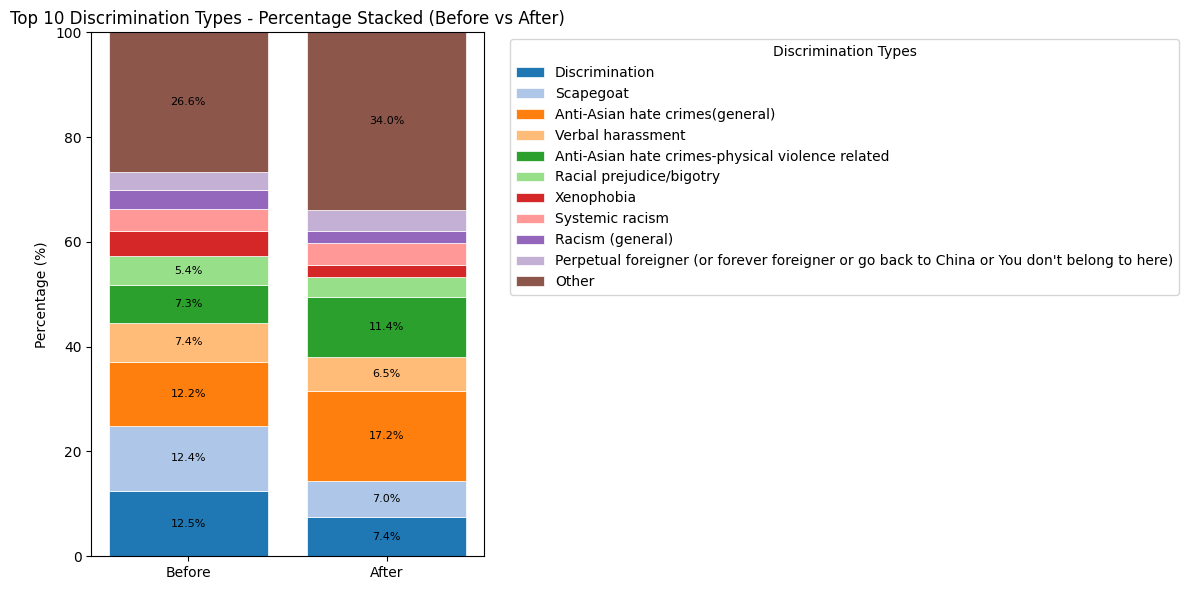

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假設 before_event 和 after_event 是 Pandas Series
data = pd.DataFrame({
    "Before": before_event,
    "After": after_event
})

# 選取事件前的前十名類型
top10_types = data["Before"].nlargest(10).index
data_top10 = data.loc[top10_types]

# 計算其他類型的總和（可選）
other_before = data["Before"].sum() - data_top10["Before"].sum()
other_after = data["After"].sum() - data_top10["After"].sum()
data_top10.loc["Other"] = [other_before, other_after]

# 轉換為百分比（每列總和為100%）
data_pct = data_top10.div(data_top10.sum(axis=0), axis=1) * 100

# 繪圖設定
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab20.colors[:len(data_pct)]  # 顏色列表

# 繪製堆疊長條（百分比版）
bottom_before = np.zeros(1)  # Before 的起始點
bottom_after = np.zeros(1)   # After 的起始點

for i, (dtype, row) in enumerate(data_pct.iterrows()):
    # Before 長條
    ax.bar(["Before"], [row["Before"]], bottom=bottom_before,
           label=dtype, color=colors[i], edgecolor="white", linewidth=0.5)
    # After 長條
    ax.bar(["After"], [row["After"]], bottom=bottom_after,
           color=colors[i], edgecolor="white", linewidth=0.5)

    # 標註百分比（可選）
    if row["Before"] > 5:  # 僅顯示占比>5%的標籤
        ax.text(0, bottom_before + row["Before"]/2, f"{row['Before']:.1f}%",
                ha="center", va="center", color="black", fontsize=8)
    if row["After"] > 5:
        ax.text(1, bottom_after + row["After"]/2, f"{row['After']:.1f}%",
                ha="center", va="center", color="black", fontsize=8)

    bottom_before += row["Before"]
    bottom_after += row["After"]

# 美化設定
ax.set_title("Top 10 Discrimination Types - Percentage Stacked (Before vs After)")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)  # 確保Y軸顯示0-100%
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Discrimination Types")
plt.tight_layout()
plt.savefig("stacked_bar_percentage.png", dpi=300)
plt.show()